In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from io import StringIO
from IPython.display import Image
import re
from tqdm import tqdm
import pickle
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import itertools

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

In [2]:
path = 'D:\\IOT_Research\\'

### The data set was experimentally obtained with a hydraulic test rig. This test rig consists of a primary working and a secondary cooling-filtration circuit which are connected via the oil tank. The system cyclically repeats constant load cycles (duration 60 seconds) and measures process values such as pressures, volume flows and temperatures while the condition of four hydraulic components (cooler, valve, pump and accumulator) is quantitatively varied.

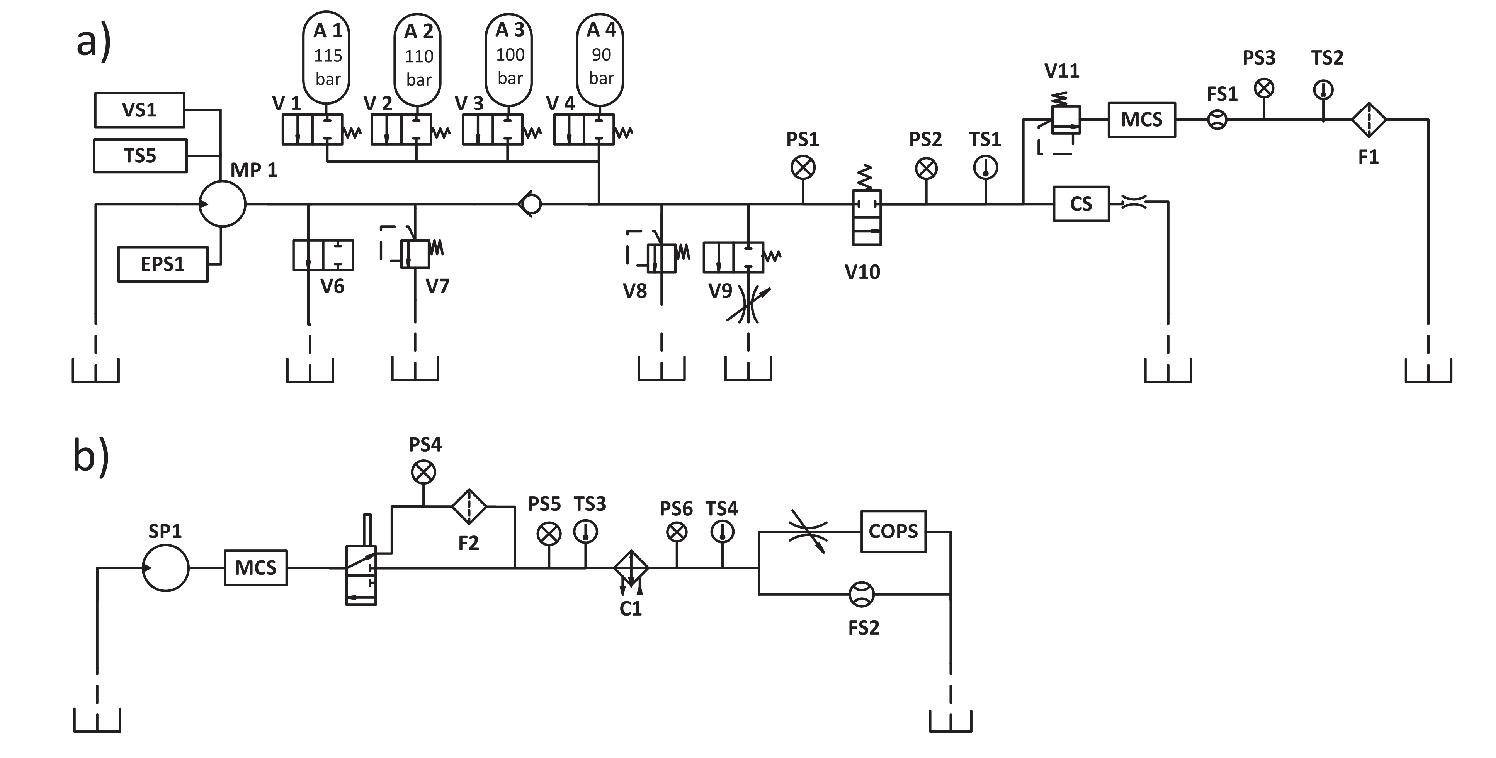

In [3]:
Image(path+'hydro_machine_data\cropped_helwig2015\cropped_helwig2015-2.jpg')

In [4]:
desc = """Sensor		Physical quantity		Unit		Sampling rate
PS1		Pressure			bar		100 Hz
PS2		Pressure			bar		100 Hz
PS3		Pressure			bar		100 Hz
PS4		Pressure			bar		100 Hz
PS5		Pressure			bar		100 Hz
PS6		Pressure			bar		100 Hz
EPS1		Motor power			W		100 Hz
FS1		Volume flow			l/min		10 Hz
FS2		Volume flow			l/min		10 Hz
TS1		Temperature			°C		1 Hz
TS2		Temperature			°C		1 Hz
TS3		Temperature			°C		1 Hz
TS4		Temperature			°C		1 Hz
VS1		Vibration			mm/s		1 Hz
CE		Cooling efficiency (virtual)	%		1 Hz
CP		Cooling power (virtual)		kW		1 Hz
SE		Efficiency factor		%		1 Hz"""

TESTDATA = StringIO(re.sub('\t','',re.sub('\t\t',',',desc)))
df = pd.read_csv(TESTDATA)
df.loc[14,'Physical quantity'] = 'Cooling efficiency (virtual)'
df.loc[14,'Unit'] = '%'
df.loc[14,'Sampling rate'] = '1 Hz'
df

,Sensor,Physical quantity,Unit,Sampling rate
0,PS1,Pressure,bar,100 Hz
1,PS2,Pressure,bar,100 Hz
2,PS3,Pressure,bar,100 Hz
3,PS4,Pressure,bar,100 Hz
4,PS5,Pressure,bar,100 Hz
5,PS6,Pressure,bar,100 Hz
6,EPS1,Motor power,W,100 Hz
7,FS1,Volume flow,l/min,10 Hz
8,FS2,Volume flow,l/min,10 Hz
9,TS1,Temperature,°C,1 Hz


## The process was divided according to PS1 variable into 12 parts. Mean, Median, Standart deviation, skewness, kurtosis were calculated features for all 12 parts and also for overall preocess (labeled as part 13).

In [5]:
def data_splitter_1000(data):
    splitted_data = [0 for i in range(13)]
    splitted_data[0] = data.loc[:,:80]
    splitted_data[1] = data.loc[:,81:934]
    splitted_data[2] = data.loc[:,935:1100]
    splitted_data[3] = data.loc[:,1100:1900]
    splitted_data[4] = data.loc[:,1901:2000]
    splitted_data[5] = data.loc[:,2001:2900]
    splitted_data[6] = data.loc[:,2901:3000]
    splitted_data[7] = data.loc[:,3001:3900]
    splitted_data[8] = data.loc[:,3901:4000]
    splitted_data[9] = data.loc[:,4001:4900]
    splitted_data[10] = data.loc[:,4901:5000]
    splitted_data[11] = data.loc[:,5001:]
    splitted_data[12] = data    
    return splitted_data

def data_splitter_100(data):
    splitted_data = [0 for i in range(13)]
    splitted_data[0] = data.loc[:,:8]
    splitted_data[1] = data.loc[:,9:93]
    splitted_data[2] = data.loc[:,94:110]
    splitted_data[3] = data.loc[:,110:190]
    splitted_data[4] = data.loc[:,191:200]
    splitted_data[5] = data.loc[:,201:290]
    splitted_data[6] = data.loc[:,291:300]
    splitted_data[7] = data.loc[:,301:390]
    splitted_data[8] = data.loc[:,391:400]
    splitted_data[9] = data.loc[:,401:490]
    splitted_data[10] = data.loc[:,491:500]
    splitted_data[11] = data.loc[:,501:]
    splitted_data[12] = data    
    return splitted_data

def data_splitter_10(data):
    splitted_data = [0 for i in range(13)]
    splitted_data[0] = data.loc[:,0:0]
    splitted_data[1] = data.loc[:,1:9]
    splitted_data[2] = data.loc[:,10:10]
    splitted_data[3] = data.loc[:,11:19]
    splitted_data[4] = data.loc[:,20:20]
    splitted_data[5] = data.loc[:,21:29]
    splitted_data[6] = data.loc[:,30:31]
    splitted_data[7] = data.loc[:,31:39]
    splitted_data[8] = data.loc[:,40:40]
    splitted_data[9] = data.loc[:,41:49]
    splitted_data[10] = data.loc[:,50:50]
    splitted_data[11] = data.loc[:,51:]
    splitted_data[12] = data    
    return splitted_data

In [6]:
%%time
PS1 = pd.read_csv(path+'hydro_machine_data\PS1.txt', sep="\t", header=None) #1000
PS2 = pd.read_csv(path+'hydro_machine_data\PS2.txt', sep="\t", header=None) #1000
PS3 = pd.read_csv(path+'hydro_machine_data\PS3.txt', sep="\t", header=None) #1000
PS4 = pd.read_csv(path+'hydro_machine_data\PS4.txt', sep="\t", header=None) #1000
PS5 = pd.read_csv(path+'hydro_machine_data\PS5.txt', sep="\t", header=None) #1000
PS6 = pd.read_csv(path+'hydro_machine_data\PS6.txt', sep="\t", header=None) #1000
EPS1 = pd.read_csv(path+'hydro_machine_data\EPS1.txt', sep="\t", header=None) #100
FS1 = pd.read_csv(path+'hydro_machine_data\FS1.txt', sep="\t", header=None) #100
FS2 = pd.read_csv(path+'hydro_machine_data\FS2.txt', sep="\t", header=None) #100
TS1 = pd.read_csv(path+'hydro_machine_data\TS1.txt', sep="\t", header=None) #10
TS2 = pd.read_csv(path+'hydro_machine_data\TS2.txt', sep="\t", header=None) #10
TS3 = pd.read_csv(path+'hydro_machine_data\TS3.txt', sep="\t", header=None) #10
TS4 = pd.read_csv(path+'hydro_machine_data\TS4.txt', sep="\t", header=None) #10
VS1 = pd.read_csv(path+'hydro_machine_data\VS1.txt', sep="\t", header=None) #10
CE = pd.read_csv(path+'hydro_machine_data\CE.txt', sep="\t", header=None) #10
CP = pd.read_csv(path+'hydro_machine_data\CP.txt', sep="\t", header=None) #10
SE = pd.read_csv(path+'hydro_machine_data\SE.txt', sep="\t", header=None) #10

target = pd.read_csv(path+'hydro_machine_data\profile.txt', sep="\t", header=None)
target.columns = ['Cooler','Valve','Pump','Accumulator','Stable']

Wall time: 17.2 s


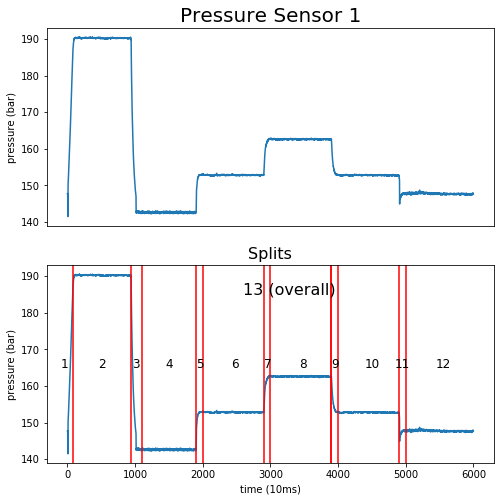

In [7]:
fig,(ax1,ax2) = plt.subplots(2,1, figsize = (8,8))

PS1 = pd.read_csv(r'D:\IOT_Research\hydro_machine_data\PS1.txt', sep="\t", header=None)
ax1.plot(PS1.loc[50])
ax1.set_title('Pressure Sensor 1',fontsize = 20)
ax1.get_xaxis().set_visible(False)
ax1.set_ylabel('pressure (bar)')

ax2.plot(PS1.loc[50])
ax2.text(2600,185,'13 (overall)',fontsize=16)
ax2.axvline(x=80,color = 'r')
ax2.text(-100,165,'1',fontsize=12)
ax2.axvline(x=934,color = 'r')
ax2.text(450,165,'2',fontsize=12)
ax2.axvline(x=1100,color = 'r')
ax2.text(950,165,'3',fontsize=12)
ax2.axvline(x=1900,color = 'r')
ax2.text(1450,165,'4',fontsize=12)
ax2.axvline(x=2000,color = 'r')
ax2.text(1900,165,'5',fontsize=12)
ax2.axvline(x=2900,color = 'r')
ax2.text(2420,165,'6',fontsize=12)
ax2.axvline(x=3000,color = 'r')
ax2.text(2900,165,'7',fontsize=12)
ax2.axvline(x=3900,color = 'r')
ax2.text(3420,165,'8',fontsize=12)
ax2.axvline(x=4000,color = 'r')
ax2.text(3900,165,'9',fontsize=12)
ax2.axvline(x=3900,color = 'r')
ax2.text(4400,165,'10',fontsize=12)
ax2.axvline(x=4900,color = 'r')
ax2.text(4840,165,'11',fontsize=12)
ax2.axvline(x=5000,color = 'r')
ax2.text(5450,165,'12',fontsize=12)
ax2.set_title('Splits',fontsize = 16)
ax2.set_ylabel('pressure (bar)')
ax2.set_xlabel('time (10ms)')
#fig.savefig(path+'sensor_splits.png',bbox_inches = 'tight')
plt.show()

In [8]:
PS1_splitted = data_splitter_1000(PS1)
PS2_splitted = data_splitter_1000(PS2)
PS3_splitted = data_splitter_1000(PS3)
PS4_splitted = data_splitter_1000(PS4)
PS5_splitted = data_splitter_1000(PS5)
PS6_splitted = data_splitter_1000(PS6)
EPS1_splitted = data_splitter_100(EPS1)
FS1_splitted = data_splitter_100(FS1)
FS2_splitted = data_splitter_100(FS2)
TS1_splitted = data_splitter_10(TS1)
TS2_splitted = data_splitter_10(TS2)
TS3_splitted = data_splitter_10(TS3)
TS4_splitted = data_splitter_10(TS4)
VS1_splitted = data_splitter_10(VS1)
CE_splitted = data_splitter_10(CE)
CP_splitted = data_splitter_10(CP)
SE_splitted = data_splitter_10(SE)

In [9]:
# helper for apply
def find_slope(x,y):
    if len(x)>1:
        reg = np.polyfit(x,y, 1)
        return reg[0]
    else:
        return 1

In [10]:
feature_df = pd.DataFrame()
def featurize(data,name):
    for count,df in enumerate(data):
        feature_df[name+'_'+str(count+1)+'_mean'] = df.mean(axis = 1)
        feature_df[name+'_'+str(count+1)+'_median'] = df.median(axis = 1)
        feature_df[name+'_'+str(count+1)+'_std'] = df.std(axis = 1)
        feature_df[name+'_'+str(count+1)+'_skewness'] = df.skew(axis = 1)
        feature_df[name+'_'+str(count+1)+'_kurtosis'] = df.kurtosis(axis = 1)
        feature_df[name+'_'+str(count+1)+'_maxpos'] = df.idxmax(axis = 1)
        feature_df[name+'_'+str(count+1)+'_slope'] = df.apply(lambda x: find_slope(df.columns, x), axis = 1)

In [11]:
%%time
featurize(PS1_splitted,'PS1')
featurize(PS2_splitted,'PS2')
featurize(PS3_splitted,'PS3')
featurize(PS4_splitted,'PS4')
featurize(PS5_splitted,'PS5')
featurize(PS6_splitted,'PS6')
featurize(EPS1_splitted,'EPS1')
featurize(FS1_splitted,'FS1')
featurize(FS2_splitted,'FS2')
featurize(TS1_splitted,'TS1')
featurize(TS2_splitted,'TS2')
featurize(TS3_splitted,'TS3')
featurize(TS4_splitted,'TS4')
featurize(VS1_splitted,'VS1')
featurize(CE_splitted,'CE')
featurize(CP_splitted,'CP')
featurize(SE_splitted,'SE')
feature_df.dropna(axis = 1,inplace = True)

Wall time: 58.9 s


In [12]:
feature_df.shape

(2205, 1411)

# Feature_df is dataframe with all features extracted from all sensors.

In [13]:
# A function to take top correlated variables for a given fault type (label)

def label_top_corrs(label,top):
    label_features = pd.concat([target[label],feature_df], axis = 1)
    c = label_features.corr()[label].abs()
    c.sort_values(axis = 0,ascending=False, inplace=True)
    return c[1:top+1]

In [14]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [15]:
from sklearn.ensemble import RandomForestClassifier as RF
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import lightgbm as LGB

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 44,va = 'bottom')
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,ha = 'center', fontsize = 11)
    plt.yticks(tick_marks, classes, rotation=90,va = 'center', fontsize = 11)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize = 20)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 32)
    plt.xlabel('Predicted label',fontsize = 32)

In [17]:
model_accuracies = pd.DataFrame(index = ['RF','CB','XGB','LGBM'], columns = ['Cooler','Valve','Pump','Accumulator'])

In [18]:
seed = 42

# Random Forest model 

In [19]:
path = 'D:\\IOT_Research\\hydro_model\\'
for label in ['Cooler','Valve','Pump','Accumulator']:
    train_accs = []
    test_accs = []  
    corrs = label_top_corrs(label,1411).dropna()
    corred_vars = list(corrs.index)
    X = feature_df[corred_vars]
    if label == 'Cooler':
        Y = target[label].map({3:0,20:1,100:2})
    elif label == 'Valve':
        Y = target[label].map({80:1, 73:0, 90:2, 100:3})
    elif label == 'Pump':
        Y = target[label]
    elif label == 'Accumulator':
        Y = target[label].map({130:3, 115:2, 100:1, 90:0})
    Xs,Ys = shuffle(X,Y, random_state = seed)
    kf = KFold(n_splits=10, random_state = seed)
    for train_index, test_index in tqdm(kf.split(X)): 
        x_train, x_test = Xs.iloc[train_index], Xs.iloc[test_index]
        y_train, y_test = Ys.iloc[train_index], Ys.iloc[test_index]
        clf = RF(n_estimators = 500, random_state = seed)
        clf.fit(x_train, y_train)
        train_acc = clf.score(x_train,y_train)
        train_accs.append(train_acc)
        test_acc = clf.score(x_test,y_test)
        test_accs.append(test_acc)

    print(label,'RF train acc mean:',np.mean(train_accs)*100, '%')
    print(label,'RF test acc mean:',np.mean(test_accs)*100, '%')
    print(label,'RF train best acc:',np.max(train_accs)*100, '%')
    print(label,'RF test best acc:',np.max(test_accs)*100, '%')
    print([round((1-t)*len(y_test)) for t in test_accs])
    model_accuracies.loc['RF',label] = np.mean(test_accs)*100

10it [00:32,  3.24s/it]


Cooler RF train acc mean: 100.0 %
Cooler RF test acc mean: 99.86363636363636 %
Cooler RF train best acc: 100.0 %
Cooler RF test best acc: 100.0 %
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0]


10it [00:58,  5.87s/it]


Valve RF train acc mean: 100.0 %
Valve RF test acc mean: 100.0 %
Valve RF train best acc: 100.0 %
Valve RF test best acc: 100.0 %
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


10it [00:50,  5.03s/it]


Pump RF train acc mean: 100.0 %
Pump RF test acc mean: 99.95475113122171 %
Pump RF train best acc: 100.0 %
Pump RF test best acc: 100.0 %
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


10it [01:38,  9.82s/it]


Accumulator RF train acc mean: 100.0 %
Accumulator RF test acc mean: 99.727478403949 %
Accumulator RF train best acc: 100.0 %
Accumulator RF test best acc: 100.0 %
[1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 3.0, 0.0]


# CatBoost

In [20]:
path = 'D:\\IOT_Research\\hydro_model\\'
for label in ['Cooler','Valve','Pump','Accumulator']:
    train_accs = []
    test_accs = []  
    corrs = label_top_corrs(label,1411).dropna()
    corred_vars = list(corrs.index)
    X = feature_df[corred_vars]
    if label == 'Cooler':
        Y = target[label].map({3:0,20:1,100:2})
    elif label == 'Valve':
        Y = target[label].map({80:1, 73:0, 90:2, 100:3})
    elif label == 'Pump':
        Y = target[label]
    elif label == 'Accumulator':
        Y = target[label].map({130:3, 115:2, 100:1, 90:0})
    Xs,Ys = shuffle(X,Y, random_state = seed)
    kf = KFold(n_splits=10, random_state = seed)
    for train_index, test_index in tqdm(kf.split(X)): 
        x_train, x_test = Xs.iloc[train_index], Xs.iloc[test_index]
        y_train, y_test = Ys.iloc[train_index], Ys.iloc[test_index]
        clf = CatBoostClassifier(iterations=50, depth=5,
                                 learning_rate=0.5, loss_function='MultiClass',
                                 verbose=False, random_seed = seed)
        clf.fit(x_train, y_train)
        train_acc = clf.score(x_train,y_train)
        train_accs.append(train_acc)
        test_acc = clf.score(x_test,y_test)
        test_accs.append(test_acc)

    print(label,'CB train acc mean:',np.mean(train_accs)*100, '%')
    print(label,'CB test acc mean:',np.mean(test_accs)*100, '%')
    print(label,'CB train best acc:',np.max(train_accs)*100, '%')
    print(label,'CB test best acc:',np.max(test_accs)*100, '%')
    print([round((1-t)*len(y_test)) for t in test_accs])
    model_accuracies.loc['CB',label] = np.mean(test_accs)*100

10it [02:49, 17.02s/it]


Cooler CB train acc mean: 100.0 %
Cooler CB test acc mean: 99.90909090909092 %
Cooler CB train best acc: 100.0 %
Cooler CB test best acc: 100.0 %
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0]


10it [03:48, 22.91s/it]


Valve CB train acc mean: 100.0 %
Valve CB test acc mean: 100.0 %
Valve CB train best acc: 100.0 %
Valve CB test best acc: 100.0 %
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


10it [02:49, 16.63s/it]


Pump CB train acc mean: 100.0 %
Pump CB test acc mean: 99.7280954339778 %
Pump CB train best acc: 100.0 %
Pump CB test best acc: 100.0 %
[0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]


10it [03:55, 23.57s/it]


Accumulator CB train acc mean: 99.9697631429268 %
Accumulator CB test acc mean: 99.22912381735912 %
Accumulator CB train best acc: 100.0 %
Accumulator CB test best acc: 100.0 %
[6.0, 0.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 3.0, 1.0]


# XGBoost

In [21]:
path = 'D:\\IOT_Research\\hydro_model\\'
#seeds = [10,20,30,40,50,60,70,80,90,100]
for label in ['Cooler','Valve','Pump','Accumulator']:
    train_accs = []
    test_accs = []
    corrs = label_top_corrs(label,1411).dropna()
    corred_vars = list(corrs.index)
    X = feature_df[corred_vars]
    if label == 'Cooler':
        Y = target[label].map({3:0,20:1,100:2})
    elif label == 'Valve':
        Y = target[label].map({80:1, 73:0, 90:2, 100:3})
    elif label == 'Pump':
        Y = target[label]
    elif label == 'Accumulator':
        Y = target[label].map({130:3, 115:2, 100:1, 90:0})
    Xs,Ys = shuffle(X,Y, random_state = seed)
    kf = KFold(n_splits=10, random_state = seed)
    for train_index, test_index in tqdm(kf.split(X)): 
        x_train, x_test = Xs.iloc[train_index], Xs.iloc[test_index]
        y_train, y_test = Ys.iloc[train_index], Ys.iloc[test_index]
        clf = XGBClassifier(max_depth = 5, reg_lambda = 8,learning_rate = 0.4)
        clf.fit(x_train, y_train)
        train_acc = clf.score(x_train,y_train)
        train_accs.append(train_acc)
        test_acc = clf.score(x_test,y_test)
        test_accs.append(test_acc)

    print(label,'XGB train acc mean:',np.mean(train_accs)*100, '%')
    print(label,'XGB test acc mean:',np.mean(test_accs)*100, '%')
    print(label,'XGB train best acc:',np.max(train_accs)*100, '%')
    print(label,'XGB test best acc:',np.max(test_accs)*100, '%')
    print([round((1-t)*len(y_test)) for t in test_accs])
    model_accuracies.loc['XGB',label] = np.mean(test_accs)*100

10it [02:09, 12.82s/it]


Cooler XGB train acc mean: 100.0 %
Cooler XGB test acc mean: 99.95454545454547 %
Cooler XGB train best acc: 100.0 %
Cooler XGB test best acc: 100.0 %
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]


10it [02:55, 17.54s/it]


Valve XGB train acc mean: 100.0 %
Valve XGB test acc mean: 100.0 %
Valve XGB train best acc: 100.0 %
Valve XGB test best acc: 100.0 %
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


10it [02:44, 16.48s/it]


Pump XGB train acc mean: 100.0 %
Pump XGB test acc mean: 99.7280954339778 %
Pump XGB train best acc: 100.0 %
Pump XGB test best acc: 100.0 %
[0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]


10it [06:27, 38.80s/it]


Accumulator XGB train acc mean: 100.0 %
Accumulator XGB test acc mean: 99.50082270670507 %
Accumulator XGB train best acc: 100.0 %
Accumulator XGB test best acc: 100.0 %
[3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 3.0, 3.0, 0.0]


# LGBM

In [22]:
path = 'D:\\IOT_Research\\hydro_model\\'
#seeds = [10,20,30,40,50,60,70,80,90,100]
for label in ['Cooler','Valve','Pump','Accumulator']:
    train_accs = []
    test_accs = []
    corrs = label_top_corrs(label,1411).dropna()
    corred_vars = list(corrs.index)
    X = feature_df[corred_vars]
    if label == 'Cooler':
        Y = target[label].map({3:0,20:1,100:2})
    elif label == 'Valve':
        Y = target[label].map({80:1, 73:0, 90:2, 100:3})
    elif label == 'Pump':
        Y = target[label]
    elif label == 'Accumulator':
        Y = target[label].map({130:3, 115:2, 100:1, 90:0})
    Xs,Ys = shuffle(X,Y, random_state = seed)
    kf = KFold(n_splits=10, random_state = seed)
    for train_index, test_index in tqdm(kf.split(X)): 
        x_train, x_test = Xs.iloc[train_index], Xs.iloc[test_index]
        y_train, y_test = Ys.iloc[train_index], Ys.iloc[test_index]
        clf = LGB.LGBMClassifier(max_depth = 5, n_estimators = 100,learning_rate = 0.05)
        clf.fit(x_train, y_train)
        train_acc = clf.score(x_train,y_train)
        train_accs.append(train_acc)
        test_acc = clf.score(x_test,y_test)
        test_accs.append(test_acc)

    print(label,'LGBM train acc mean:',np.mean(train_accs)*100, '%')
    print(label,'LGBM test acc mean:',np.mean(test_accs)*100, '%')
    print(label,'LGBM train best acc:',np.max(train_accs)*100, '%')
    print(label,'LGBM test best acc:',np.max(test_accs)*100, '%')
    print([round((1-t)*len(y_test)) for t in test_accs])
    model_accuracies.loc['LGBM',label] = np.mean(test_accs)*100

10it [03:14, 19.43s/it]


Cooler LGBM train acc mean: 100.0 %
Cooler LGBM test acc mean: 99.95454545454547 %
Cooler LGBM train best acc: 100.0 %
Cooler LGBM test best acc: 100.0 %
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]


10it [04:31, 26.33s/it]


Valve LGBM train acc mean: 100.0 %
Valve LGBM test acc mean: 100.0 %
Valve LGBM train best acc: 100.0 %
Valve LGBM test best acc: 100.0 %
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


10it [03:39, 21.93s/it]


Pump LGBM train acc mean: 100.0 %
Pump LGBM test acc mean: 99.86425339366517 %
Pump LGBM train best acc: 100.0 %
Pump LGBM test best acc: 100.0 %
[0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


10it [05:33, 32.95s/it]


Accumulator LGBM train acc mean: 100.0 %
Accumulator LGBM test acc mean: 99.45598519127931 %
Accumulator LGBM train best acc: 100.0 %
Accumulator LGBM test best acc: 100.0 %
[4.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 3.0, 0.0]


In [23]:
model_accuracies

,Cooler,Valve,Pump,Accumulator
RF,99.8636,100,99.9548,99.7275
CB,99.9091,100,99.7281,99.2291
XGB,99.9545,100,99.7281,99.5008
LGBM,99.9545,100,99.8643,99.456
